# Chirp-Z debug script

Create a standard function-transform pair $f(x,y) \leftrightarrow \hat{f}(k_x,k_y)$. Here we use a Gaussian of radius $a$.

First, compare the results of the discrete sequence, $DFT(f(k_{x,i}, k_{y,i}))$ vs. the analytic transform, $\hat{f}(k_{x,i}, k_{y,i})$. This ensures that our baseline -- the Gaussian, the DFT of said Gaussian, the analytic $\hat{f}(\cdot)$, etc. -- are implemented correctly.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


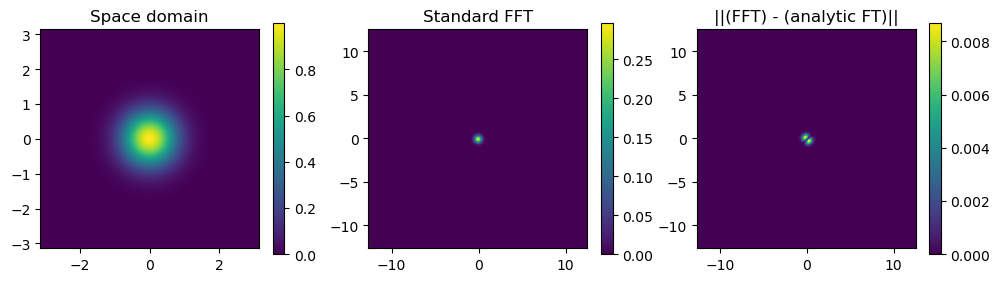

In [835]:
import torch
import matplotlib.pyplot as plt
from utils.czt import custom_fft2, custom_ifft2
from torch.fft import fft2, fftshift, ifftshift, fftfreq

%load_ext autoreload
%autoreload 2

# primal gaussian
R = torch.pi * 1.0
a = 1.3
N = 40*4

# space domain gaussian
x = torch.linspace(-R, R, N)
dx = x[1] - x[0]
xx, yy = torch.meshgrid(x, x, indexing='ij')
fs = torch.exp(-(xx ** 2 + yy ** 2) * a ** 2)# * (xx ** 2 + yy ** 2 <= R ** 2)

# frequency domain gaussian, analytic
kx = fftshift(fftfreq(len(x), dx))
kxx, kyy = torch.meshgrid(kx, kx, indexing='ij')
transform_an = lambda kxx, kyy: 1.0 / (2.0 * a ** 2) * torch.exp(-(kxx**2 + kyy**2) * (torch.pi / a) ** 2)

# compute numeric FFT and analytic FT
Fs = fftshift(fft2(ifftshift(fs))) * dx ** 2 /  (2.0 * torch.pi)
Fs_an = transform_an(kxx, kyy)


plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(fs, extent=[x[0], x[-1], x[0], x[-1]])
plt.title("Space domain")
plt.colorbar()
plt.subplot(132)
plt.imshow(torch.abs(Fs), extent=[kx[0], kx[-1], kx[0], kx[-1]])
plt.title("Standard FFT")
plt.colorbar()
plt.subplot(133)
plt.imshow(torch.abs(Fs_an - Fs), extent=[kx[0], kx[-1], kx[0], kx[-1]])
plt.title("||(FFT) - (analytic FT)||")
plt.colorbar()

Now introduce the cropped FFT (== CZT). Check that the spatial frequencies `ks` are set correctly _for the CZT_; the two plots $\hat{f}_{CZT}$ and $\hat{f}_{FFT}$ should overlap perfectly.

In [836]:
k_start = -torch.pi * 0.26 * 100 / (N - 1)
k_end   =  torch.pi * 0.26 * 100 / (N - 1)
# ks = torch.linspace(k_start, k_end, N)
ks = ((kx - kx[0]) / (kx[-1] - kx[0]) * (k_end - k_start) + k_start) * kx[-1] / torch.pi


Fs_custom = custom_ifft2(fs, 
                        shape_out=fs.shape,
                        k_start=k_start, 
                        k_end=k_end, 
                        norm="backward", 
                        fftshift_input=True, 
                        include_end=True) * (x[-1] - x[0]) ** 2 / (2.0 * torch.pi)
# print(fs.shape)
# print(Fs_custom.shape)
# print(k_start, k_end)

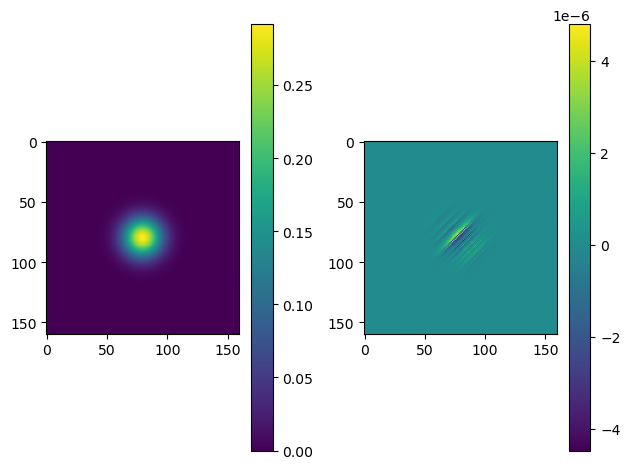

In [837]:
plt.subplot(121)
plt.imshow(Fs_custom.real)
plt.colorbar()
plt.subplot(122)
plt.imshow(Fs_custom.imag)
plt.colorbar()
plt.tight_layout()

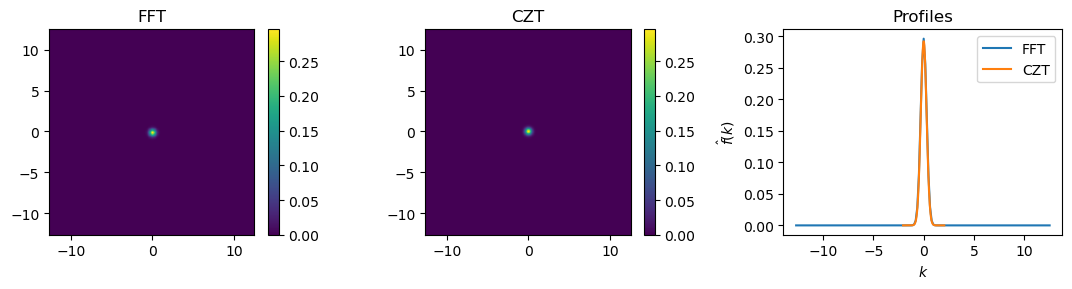

In [838]:
vmin = torch.minimum(torch.min(torch.abs(Fs)), torch.min(torch.abs(Fs_custom)))
vmax = torch.maximum(torch.max(torch.abs(Fs)), torch.max(torch.abs(Fs_custom)))

plt.figure(figsize=(11,3))

plt.subplot(131)
plt.title("FFT")
plt.imshow(torch.abs(Fs), extent=[kx[0], kx[-1], kx[0], kx[-1]], vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(132)
plt.title("CZT")
plt.imshow(torch.zeros_like(Fs, dtype=float), extent=[kx[0], kx[-1], kx[0], kx[-1]], vmin=vmin, vmax=vmax)
plt.pcolormesh(*torch.meshgrid(ks, ks, indexing='ij'), torch.abs(Fs_custom), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlim([kx[0], kx[-1]])
plt.ylim([kx[0], kx[-1]])

plt.subplot(133)
plt.title("Profiles")
plt.plot(kx, Fs[N//2].abs(), label='FFT')
plt.plot(ks, Fs_custom[N//2].abs(), label='CZT')
plt.ylabel(r"$\hat{f}(k)$")
plt.xlabel(r"$k$")
plt.legend()
plt.tight_layout()

Finally, compare the CZT-computed $\hat{f}$ against our analytic expression for $\hat{f}$.

__NOTE:__ for some reason, the CZT solution has a constant, non-zero phase angle. **This is not correct!** The Gaussian is an even function and should have a zero imaginary component, like in the analytic solution.

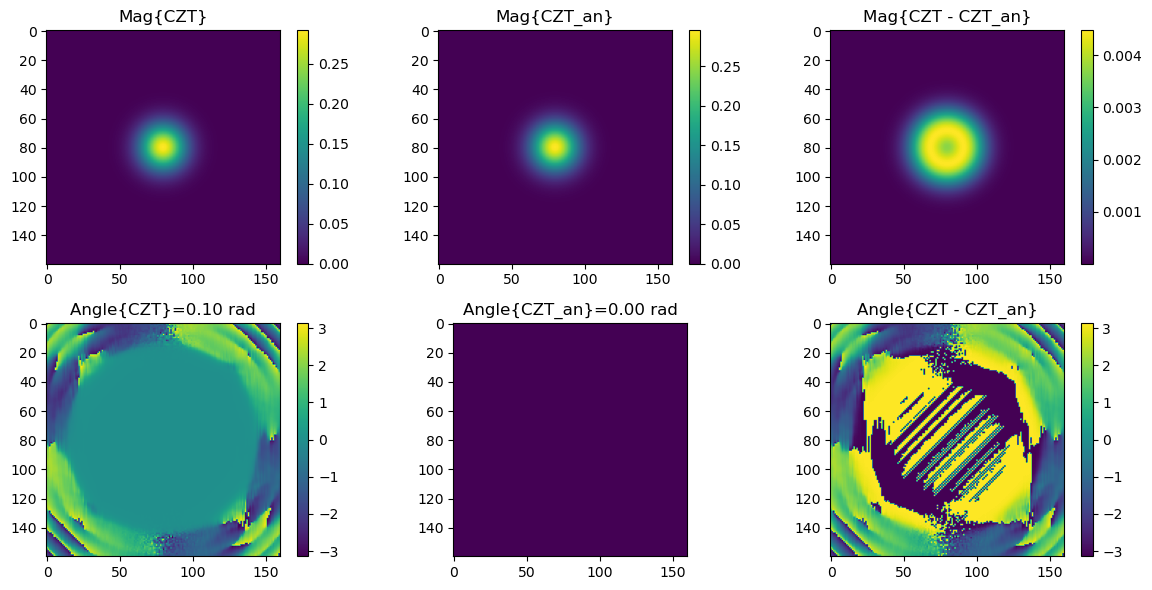

In [839]:
Fs_custom_an = transform_an(*torch.meshgrid(ks, ks, indexing='ij'))

plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title("Mag{CZT}")
plt.imshow(torch.abs(Fs_custom))
plt.colorbar()
plt.subplot(234)
plt.title("Angle{CZT}=" + f"{torch.angle(Fs_custom).mean():.2f} rad")
plt.imshow(torch.angle(Fs_custom))
plt.colorbar()

plt.subplot(232)
plt.title("Mag{CZT_an}")
plt.imshow(torch.abs(Fs_custom_an))
plt.colorbar()
plt.subplot(235)
plt.title("Angle{CZT_an}=" + f"{torch.angle(Fs_custom_an).mean():.2f} rad")
plt.imshow(torch.angle(Fs_custom_an))
# plt.colorbar()

plt.subplot(233)
plt.title("Mag{CZT - CZT_an}")
plt.imshow(torch.abs(torch.abs(Fs_custom) - torch.abs(Fs_custom_an)))
plt.colorbar()
plt.subplot(236)
plt.title("Angle{CZT - CZT_an}")
plt.imshow(torch.angle(Fs_custom - Fs_custom_an))
plt.colorbar()
plt.tight_layout()

In [840]:
approx = Fs_custom
true = Fs_custom_an
error = torch.norm(approx - true) / torch.norm(true)
print(error)
abs_error = torch.norm(torch.abs(approx) - torch.abs(true)) / torch.norm(torch.abs(true))
print(abs_error)
real_error = torch.norm(torch.real(approx) - torch.real(true)) / torch.norm(torch.real(true))
print(real_error)

tensor(0.0277)
tensor(0.0277)
tensor(0.0277)


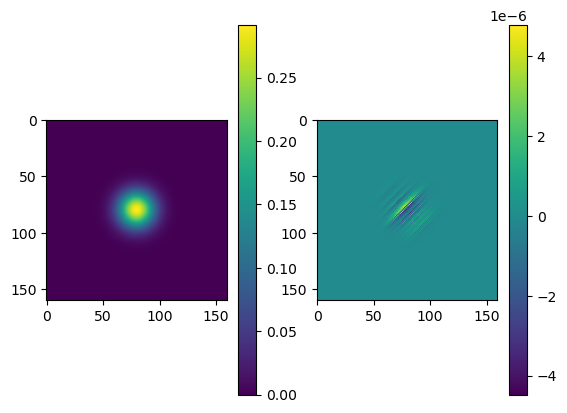

In [841]:
plt.subplot(121)
plt.imshow(approx.real)
plt.colorbar()
plt.subplot(122)
plt.imshow(approx.imag)
plt.colorbar()

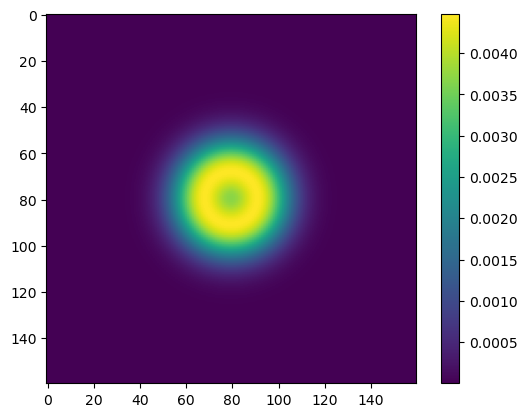

In [842]:
plt.imshow((approx - true).abs())
plt.colorbar()

In [843]:
print((approx - true).abs().mean(), (approx - true).abs().max())

print((approx.abs() - true.abs()).abs().mean(), (approx.abs() - true.abs()).abs().max())

tensor(0.0003) tensor(0.0045)
tensor(0.0003) tensor(0.0045)
